This lesson leverages with work at https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a with slight modifications and additional explanation.

#System Setup
This first step sets up the Google Collab Cloud Environment by running some system level commands. This includes installting the Java Development Toolkit, Spark (3.1) with Hadoop (3.2), and the python module FindSpark. All necessary for the example regression analysis we will do later in the code.

**Note on Syntax:** The "!" at the beginning of a command runs an operating system command. You'll see this later when we download the dataset also.

**Additional Note:** This step will take about 30 seconds. It installs a significant amount of complex software.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf spark-3.4.0-bin-hadoop3.tgz
!pip install -q findspark

This step will set the home paths for the Java Toolkit and Spark software packages installed in the previous step. We're still in the runtime enviroment set up, this will need to be done on all cloud enviroments that provide only Operating System level setup.

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"
print("Environment Set")

Environment Set


Here we import and bind the Spark installation with the regular Python libraries. After this Spark can be accessed and used as a regular Python library. The use of Spark at this point becomes transparent to the user and all cloud-like functionality is done in the background.

In [3]:
import findspark
findspark.init()
print("Findspark Initialized")

Findspark Initialized


Import Spark methods to bind the spark installation to the data set. Spark Context (sc) and SQL Context (sqlContext) create an RDD (Spark Data Type) and Data Frames for structured data processing.

In [4]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()
sqlContext = SQLContext(sc)
print("PySpark libraries imported and SQL Context set")

/content/spark-3.4.0-bin-hadoop3/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


PySpark libraries imported and SQL Context set


# Get the data

Housing data from the Boston Area is collected from GitHub via the HTTP protocol and delivered to a local Google Colab location to be accessed. It is then read into a Data Frame and the first five rows are printed out as a sanity check. Looks like legitimate data, so we can proceed with formatting it for analysis.

In [5]:
!wget https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/MASS/Boston.csv
house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('Boston.csv')
house_df.take(5)

--2023-08-10 05:57:04--  https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/MASS/Boston.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37658 (37K) [text/plain]
Saving to: ‘Boston.csv’

Boston.csv          100%[===================>]  36.78K  --.-KB/s    in 0.004s  

2023-08-10 05:57:05 (9.43 MB/s) - ‘Boston.csv’ saved [37658/37658]



[Row(_c0=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0),
 Row(_c0=2, crim=0.02731, zn=0.0, indus=7.07, chas=0, nox=0.469, rm=6.421, age=78.9, dis=4.9671, rad=2, tax=242, ptratio=17.8, black=396.9, lstat=9.14, medv=21.6),
 Row(_c0=3, crim=0.02729, zn=0.0, indus=7.07, chas=0, nox=0.469, rm=7.185, age=61.1, dis=4.9671, rad=2, tax=242, ptratio=17.8, black=392.83, lstat=4.03, medv=34.7),
 Row(_c0=4, crim=0.03237, zn=0.0, indus=2.18, chas=0, nox=0.458, rm=6.998, age=45.8, dis=6.0622, rad=3, tax=222, ptratio=18.7, black=394.63, lstat=2.94, medv=33.4),
 Row(_c0=5, crim=0.06905, zn=0.0, indus=2.18, chas=0, nox=0.458, rm=7.147, age=54.2, dis=6.0622, rad=3, tax=222, ptratio=18.7, black=396.9, lstat=5.33, medv=36.2)]

Let's take a look at the data schema to determine the data types we'll be working with. All data is in the form of integer or double, so should work well with a standard regression analysis. **Note:** the first column named "_c0" is simply a row number and will not be used in the analysis.

In [6]:
house_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



Ok, let's look even closer at the data set, this will provide some base numerical analysis including the Mean, Standard Deviation, Minimum, and Maximum values for each variable.

Here is a more detailed description of each variable:

CRIM — per capita crime rate by town.

ZN — proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS — proportion of non-retail business acres per town.

CHAS — Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

NOX — nitrogen oxides concentration (parts per 10 million).

RM — average number of rooms per dwelling.

AGE — proportion of owner-occupied units built prior to 1940.

DIS — weighted mean of distances to five Boston employment centres.

RAD — index of accessibility to radial highways.

TAX — full-value property-tax rate per $10,000.

PTRATIO — pupil-teacher ratio by town.

BLACK — 1000(Bk — 0.63)² where Bk is the proportion of blacks by town.

LSTAT — lower status of the population (percent).

MV — median value of owner-occupied homes in $1000s. This is the target variable.

**Note:** This step uses the pandas Python library which is used for data manipulation and analysis. We are calling this library 'pd' for brevity.

In [7]:
import pandas as pd
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
_c0,506,253.5,146.2138844296259,1,506
crim,506,3.6135235573122535,8.601545105332491,0.00632,88.9762
zn,506,11.363636363636363,23.32245299451514,0.0,100.0
indus,506,11.136778656126504,6.860352940897589,0.46,27.74
chas,506,0.0691699604743083,0.2539940413404101,0,1
nox,506,0.5546950592885372,0.11587767566755584,0.385,0.871
rm,506,6.284634387351787,0.7026171434153232,3.561,8.78
age,506,68.57490118577078,28.148861406903595,2.9,100.0
dis,506,3.795042687747034,2.10571012662761,1.1296,12.1265


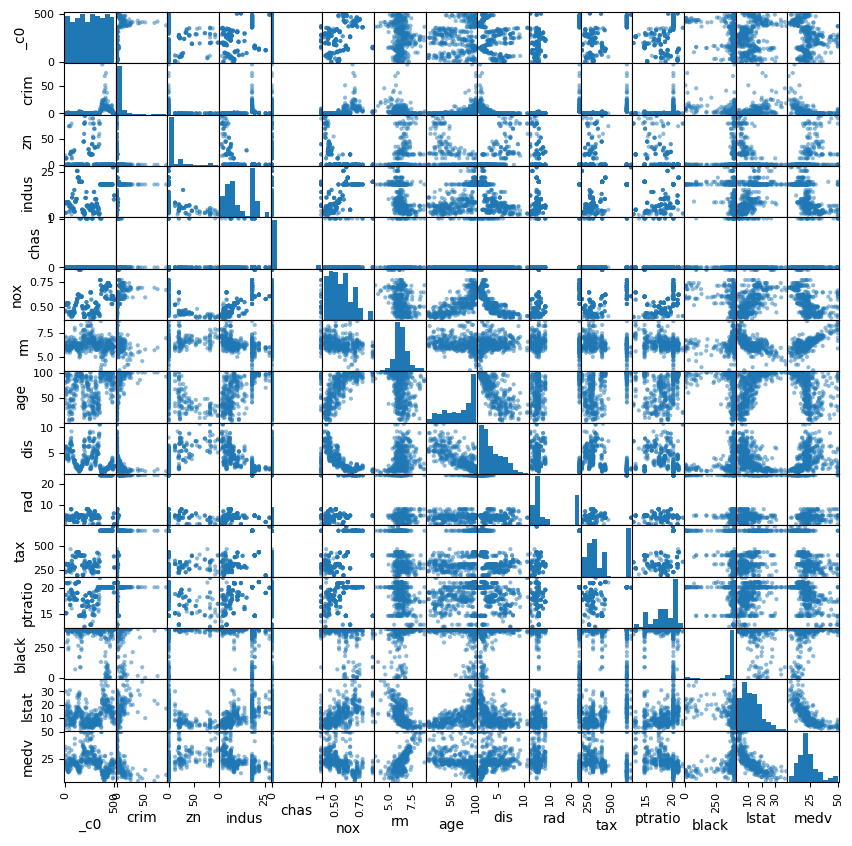

In [8]:
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False,0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10,10))

Look for coorelations using the Median Value target variable. Remember the correlation coefficient tells you how strong the positive (close to 1) or negative (close to -1) the relationship is. Which variable has the strongest postive correlation (increases the median value of the home)? Which variable has the strongest negative correlation (decrease the median value of the home)? Does this make real world sense based on what you know about home values?

**Note:** We are using the six library here it provides utility functions for smoothing over the differences between the Python versions with the goal of writing Python code that is compatible on both Python versions

In [9]:
import six
for i in house_df.columns:
  if not ( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
    print( "Correlation to MV for ", i, house_df.stat.corr("medv", i))

Correlation to MV for  _c0 -0.22660364293533927
Correlation to MV for  crim -0.38830460858681154
Correlation to MV for  zn 0.3604453424505433
Correlation to MV for  indus -0.4837251600283728
Correlation to MV for  chas 0.1752601771902987
Correlation to MV for  nox -0.4273207723732821
Correlation to MV for  rm 0.6953599470715401
Correlation to MV for  age -0.3769545650045961
Correlation to MV for  dis 0.249928734085904
Correlation to MV for  rad -0.38162623063977735
Correlation to MV for  tax -0.46853593356776674
Correlation to MV for  ptratio -0.5077866855375622
Correlation to MV for  black 0.3334608196570661
Correlation to MV for  lstat -0.7376627261740145
Correlation to MV for  medv 1.0


Let's prepare the data for a machine learning analysis. For this we need only features and labels. We also look at the first 5 rows to be sure we have the data in the proper format.

In [10]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols= ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'black', 'lstat'], outputCol='features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'medv'])
vhouse_df.show(5)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
+--------------------+----+
only showing top 5 rows



Now we'll need to split the sets into a training set and a testing set. We'll do this randomly and use 70% of the set to train and 30% for testing.

In [11]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]
print("Dataset Split")

Dataset Split


Time to train the Linear Regression model and look at the Coefficients and Intercept of that model.

In [12]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol= 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [-0.031635397865998595,0.013018516998290982,0.0,2.8429912712008583,-5.812247272094687,4.156475940308849,0.0,-0.6444970780114696,-0.0008857546992755862,-0.8753832010250752,0.0027983063460940982,-0.5388844849212325]
Intercept: 24.19372951679323


Look at the Root Mean Square Error (difference between predicted values and actual models) and R-Squared results for the model. In this case 74% (this figure may vary depending on the random split done above) of the variability can be explained using the model.

In [13]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.944532
r2: 0.719636


RMSE is meaningless without looking at the value of the medv variable, so let's take a look.

In [14]:
train_df.describe().show()

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               355|
|   mean|22.699999999999996|
| stddev|  9.35140401555547|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



Let's try some predictions using the test data set. First we'll find the R-Squared.

In [15]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction", "medv", "features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medv", metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 30.76516680031257|24.0|[0.00632,18.0,2.3...|
|31.020279697174182|32.2|[0.00906,90.0,2.9...|
|31.967222713737467|32.7|[0.01301,35.0,1.5...|
| 31.59734661245752|31.6|[0.01432,100.0,1....|
|27.643468796035265|24.5|[0.01501,80.0,2.0...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.698928


And now the RMSE.

In [16]:
test_result = lr_model.evaluate(test_df)
print('Root Mean Squared Error (RMSE) on test data = %g' % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 4.83532


And now some analytics from the training along with residuals.

In [17]:
print("Number of Iterations: %d" % trainingSummary.totalIterations)
print("Objective History %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show(5)

Number of Iterations: 10
Objective History [0.5000000000000004, 0.4347233307111692, 0.22537907814339342, 0.20514363163286314, 0.1806289305897887, 0.17825891775109404, 0.1775263663850606, 0.1762599646964338, 0.17588532001830892, 0.17580204889981077, 0.17575882362082976]
+-------------------+
|          residuals|
+-------------------+
| -5.771081568115772|
|  5.205634342663686|
| 2.1083753403456313|
|  11.45481977499152|
|-1.7876322559243754|
+-------------------+
only showing top 5 rows



Here we will use this model to create some predictions.

In [18]:
predictions = lr_model.transform(test_df)
predictions.select("prediction", "medv", 'features').show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 30.76516680031257|24.0|[0.00632,18.0,2.3...|
|31.020279697174182|32.2|[0.00906,90.0,2.9...|
|31.967222713737467|32.7|[0.01301,35.0,1.5...|
| 31.59734661245752|31.6|[0.01432,100.0,1....|
|27.643468796035265|24.5|[0.01501,80.0,2.0...|
+------------------+----+--------------------+
only showing top 5 rows



Creating a decision tree regression to determine which features are the most important. More about decision tree learning can be seen at: https://en.wikipedia.org/wiki/Decision_tree_learning.

In [19]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol='features', labelCol='medv')
dt_model = dt.fit(train_df)
dt_prediction = dt_model.transform(test_df)
dt_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_prediction)
print("Root Mean Square Error (RMSE) on test data = % g" % rmse)

Root Mean Square Error (RMSE) on test data =  4.0402


In [20]:
dt_model.featureImportances

SparseVector(12, {0: 0.0237, 2: 0.0057, 3: 0.0085, 4: 0.0347, 5: 0.2342, 6: 0.0024, 7: 0.0723, 8: 0.0019, 9: 0.0078, 10: 0.0219, 11: 0.5871})

In [21]:
house_df.take(1)

[Row(_c0=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

The number of rooms appears to be the most important feature to predict median value. Does this match your analysis from above?

And now a Gradient-boosted tree regression. See https://en.wikipedia.org/wiki/Gradient_boosting for a more detailed description of gradient boosting.

In [22]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol= 'features', labelCol = 'medv', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'medv', 'features').show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 27.85950632633569|24.0|[0.00632,18.0,2.3...|
|30.452496443801717|32.2|[0.00906,90.0,2.9...|
|29.298204457836146|32.7|[0.01301,35.0,1.5...|
| 33.80131851698015|31.6|[0.01432,100.0,1....|
| 26.34390639000599|24.5|[0.01501,80.0,2.0...|
+------------------+----+--------------------+
only showing top 5 rows



In [23]:
gbt_evaluator = RegressionEvaluator(labelCol="medv", predictionCol='prediction', metricName='rmse')
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.98111


Which regression method (linear, decision tree, gradient-boosted) worked best with your test data?

Now that you've done this exercise on the Google Colab notebook environment. We'll look at creating a similar notebook environment using OpenStack VMs. After we create that VM we'll repeat the steps in this exercise. I challenenge you to find a new data set, one that might be relevant to your research.